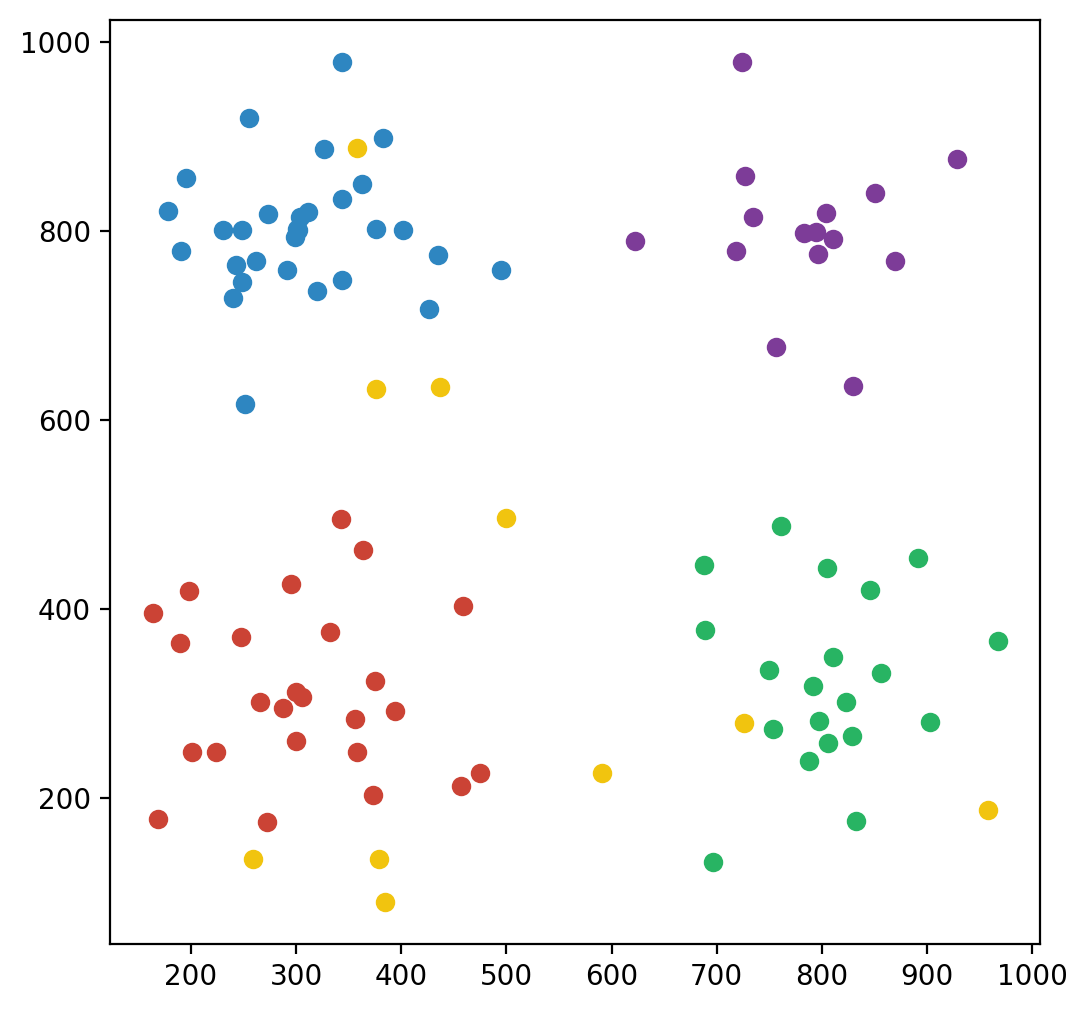

In [3]:
import gym
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import random
from numpy import random
class UAVenv(gym.Env):
    metadata = {'render.modes': ['human']}
    # Fixed Input Parameters
    NUM_USER = 100   # Number of ground user
    NUM_UAV = 5   # Number of UAV
    MAX_USER_COVER_EACH_UAV= 20  # Maximum Capacity for each UAV to cover users
    COVERAGE_XY = 1000
    grid_space = 100
    GRID_SIZE = int(COVERAGE_XY / grid_space)
    HOTSPOTS = np.array([[300, 300], [800, 800], [300, 800], [800, 300]])
    USER_DIS = [15, 20, 30, 25]
    UAV_HEIGHT = 350
    THETA = 60 * math.pi / 180 # In radian

    ## Polar to Cartesian


    ############################################################################
    ##     User Distribution // Hotspots with Uniform Distribution      ##
    ############################################################################

    def generate_user_distribution(HOTSPOTS, USER_DIS, COVERAGE_XY):

        # Shuffle the USER_DIS list
        shuffled_user_dis = USER_DIS.copy()
        random.shuffle(shuffled_user_dis)

        def pol2cart(r, theta):
            x = r * math.cos(theta)
            y = r * math.sin(theta)
            return x, y

        USER_LOC = np.zeros((sum(shuffled_user_dis) + 10, 3)) # +10 for 10 additional random users

        start_index = 0
        for i in range(len(HOTSPOTS)):
            for j in range(start_index, start_index + shuffled_user_dis[i]):
                temp_loc_r = random.uniform(-(1/5)*COVERAGE_XY, (1/5)*COVERAGE_XY)
                temp_loc_theta = random.uniform(0, 2*math.pi)
                temp_loc = pol2cart(temp_loc_r, temp_loc_theta)
                temp_loc_1, temp_loc_2 = temp_loc
                temp_loc_1 = temp_loc_1 + HOTSPOTS[i, 0]
                temp_loc_2 = temp_loc_2 + HOTSPOTS[i, 1]
                USER_LOC[j, :] = [temp_loc_1, temp_loc_2, i]
            start_index += shuffled_user_dis[i]

        temp_loc = np.random.uniform(low=0, high=COVERAGE_XY, size=(10, 2))
        USER_LOC[start_index:start_index+10, :2] = temp_loc
        USER_LOC[start_index:start_index+10, 2] = 4 # Assign region 4 to scattered users

        return USER_LOC

    def plot_user_distribution(USER_LOC):
        fig = plt.figure(figsize=(6, 6), dpi=200)
        gs = GridSpec(1, 1, figure=fig)
        ax = fig.add_subplot(gs[0:1, 0:1])
        ax.cla()

        for i in range(USER_LOC.shape[0]):
            if USER_LOC[i, 2] == 0:
                co = '#CB4335'
            elif USER_LOC[i, 2] == 1:
                co = '#7D3C98'
            elif USER_LOC[i, 2] == 2:
                co = '#2E86C1'
            elif USER_LOC[i, 2] == 3:
                co = '#28B463'
            elif USER_LOC[i, 2] == 4:
                co = '#F1C40F'

            ax.scatter(USER_LOC[i, 0], USER_LOC[i, 1], c=co, marker='o')

        plt.show()

    USER_LOC = generate_user_distribution(HOTSPOTS, USER_DIS, COVERAGE_XY)
    #print(USER_LOC)
    plot_user_distribution(USER_LOC)

    def __init__(self):
        super(UAVenv, self).__init__()
        # Five different action for the movement of each UAV
        # 0 = Right, 1 = Left, 2 = straight, 3 = back, 4 = Hover
        # Position of the UAV in space // X and Y pos
        self.u_loc = self.USER_LOC
        self.state = np.zeros((self.NUM_UAV, 4))
        self.state[:,:2] = np.zeros((self.NUM_UAV, 2), dtype=np.int32)
        self.state[:,2] = np.zeros((self.NUM_UAV,), dtype=np.float32)
        self.state[:,3] = np.zeros((self.NUM_UAV,), dtype=np.float32)
        self.flag = [0, 0, 0, 0, 0]
        self.coverage_radius = self.UAV_HEIGHT * np.tan(self.THETA / 2)

    def step(self, action, reward):
        # Take the action
        # Assignment of sub carrier band to users
        # Reshape of actions
        # Execution of one step within the environment
        # Deal with out of boundaries conditions
        isDone = False
        # Calculate the distance of every users to the UAV BS and organize as a list

        dist_u_uav = np.zeros(shape=(self.NUM_UAV, self.NUM_USER))

        for i in range(self.NUM_UAV):
            temp_x = self.state[i, 0]
            temp_y = self.state[i, 1]
            #print("Before action: ", (temp_x, temp_y))
            # one step action
            #print(action)
            if action[i] == 0:
                self.state[i, 0] = self.state[i, 0] + 1
            elif action[i] == 1:
                self.state[i, 0] = self.state[i, 0] - 1
            elif action[i] == 2:
                self.state[i, 1] = self.state[i, 1] + 1
            elif action[i] == 3:
                self.state[i, 1] = self.state[i, 1] - 1
            elif action[i] == 4:
                pass
            else:
                print("Error Action Value")

            # Take boundary condition into account // Individual flag for punishing the UAV
            if self.state[i,0] < 0 or self.state[i,0] > self.GRID_SIZE or self.state[i, 1] < 0 or self.state[i,1] > self.GRID_SIZE:
                self.state[i, 0] = temp_x
                self.state[i, 1] = temp_y
                self.flag[i] = 1     # Later penalize the reward value based on the flag
            else:
              self.flag[i] = 0

            #print("After action: ", (self.state[i, 0], self.state[i, 1]))


            # Calculation of the distance value for all UAV and User
            for l in range(self.NUM_USER):
                dist_u_uav[i, l] = math.sqrt((self.u_loc[l, 0] - (self.state[i, 0] * self.grid_space)) ** 2 + (self.u_loc[l, 1] -(self.state[i, 1] * self.grid_space)) ** 2)


        ######################
        ## Final Algorithm  ##
        ######################

        # User association to the UAV based on the distance value. First do a single sweep by all
        # the Users to request to connect to the closest UAV After the first sweep is complete the UAV will admit a
        # certain Number of Users based on capacity of each user. In the second sweep the User will request to the UAV
        # that is closest to it and UAV will admit the User if UAV has not reached its maximum capacity.

        # Connection request is a np array matrix that contains UAV Number as row and
        # User Number Connected to it on Columns and is stored in individual UAV to keep track of the
        # User requesting to connect
        # Initialize the connection_request table with zeros
        connection_request = np.zeros(shape=(self.NUM_UAV, self.NUM_USER), dtype="int")

        # For each user, find the closest UAV
        for i in range(self.NUM_USER):
            close_uav = np.argmin(dist_u_uav[:,i]) # Closest UAV index
            # If the distance between the UAV and user is within the coverage radius, then send the connection request
            if dist_u_uav[close_uav, i] <= self.coverage_radius:
                connection_request[close_uav, i] = 1 # Send the connection request

        # User association flag to keep track of which users are associated with which UAVs
        user_asso_flag = np.zeros(shape=(self.NUM_UAV, self.NUM_USER), dtype="int")
        # Total number of users associated with each UAV
        uav_asso_count = np.zeros(shape=(self.NUM_UAV,1), dtype="int")


        # Allocate users to UAVs
        for i in range(self.NUM_UAV):
        # Find the users who have sent the connection request to the current UAV
            temp_user = np.where(connection_request[i, :] == 1)
            # Sort the users based on their distance from the UAV
            temp_user_distance = dist_u_uav[i, temp_user]
            temp_user_sorted = np.argsort(temp_user_distance)
            # Convert temp_user to np_array so that it can be indexed easily
            temp_user = np.array(temp_user)
            # Get the actual index of the users who have sent the connection request, sorted based on the distance from the UAV
            temp_user_actual_idx = temp_user[0, temp_user_sorted]
            # Set the user association flag for each UAV and closest user
            for user_index in temp_user_actual_idx[0]:
                # If the number of users associated with the UAV is less than the maximum number of users it can cover, then allocate the user
                if uav_asso_count[i] < self.MAX_USER_COVER_EACH_UAV:
                  user_asso_flag[i, user_index] = 1
                  uav_asso_count[i] += 1
                else:
                    break


        # Perform a second sweep to allocate any remaining unallocated users to the closest UAV that is within range and has not reached its maximum user capacity
        # If so cover the user and set the User association flag bit of that user to 1
        for j in range(self.NUM_USER):
            if not(np.any(user_asso_flag[:, j] != 0)):
                close_uav_id = dist_u_uav[:, j]
                close_uav_id = [i[0] for i in sorted(enumerate(close_uav_id), key=lambda x: x[1])]
                for close_id in close_uav_id:
                    if dist_u_uav[close_id, j] <= self.coverage_radius:
                        if np.sum(user_asso_flag[close_id]) < self.MAX_USER_COVER_EACH_UAV:
                            uav_asso_count[close_id] += 1
                            user_asso_flag[close_id, j] = 1
                            break
        sum_user_assoc = np.sum(user_asso_flag, axis = 1)
        self.state[:, 2] = sum_user_assoc / self.MAX_USER_COVER_EACH_UAV

        overall_coverage_rate = np.sum(uav_asso_count) / self.NUM_USER
        #print(overall_coverage_rate)
        self.state[:, 3] = np.ones(self.NUM_UAV) * overall_coverage_rate


         # Calculation of reward function
        sum_user_assoc = np.sum(user_asso_flag, axis=1)
        reward_ind = np.zeros(np.size(sum_user_assoc))
        reward = 0

        for k in range(self.NUM_UAV):
            sum_user_assoc_temp = np.copy(sum_user_assoc)

            if self.flag[k] != 0:
                # Only penalized if the respective UAV is out of bound
                sum_user_assoc_temp[k] -= 2
                isDone = True

            if self.state[k, 3] > 0.8:  # Assuming coverage rate is stored in the 4th column
                sum_user_assoc_temp[k] += 3

            if self.state[k, 3] < 0.8:
                sum_user_assoc_temp[k] -= 5

            reward_ind[k] = np.average(sum_user_assoc_temp)

        reward = np.copy(reward_ind)



        # Return of obs, reward, done, info
        return np.copy(self.state).reshape(1, self.NUM_UAV * 4), reward, isDone, "empty", np.sum(sum_user_assoc)

    # Render Function
    def render(self, ax, mode='human', close=False):
        # Implement viz
        if mode == 'human':

            fig = plt.figure(figsize=(6, 6), dpi=200)
            gs = GridSpec(1, 1, figure=fig)
            ax = fig.add_subplot(gs[0:1, 0:1])
            ax.cla()
            position = self.state[:, 0:2] * self.grid_space
            # Define colors for different regions
            region_colors = {
                0: '#CB4335',
                1: '#7D3C98',
                2: '#2E86C1',
                3: '#28B463',
                4: '#F1C40F'
            }
            # Define markers for different UAVs
            markers = ['x', 'p', 's', '^', 'd']
            # Plot users with label "Users" for all regions
            for region, color in region_colors.items():
                ax.scatter(self.u_loc[self.u_loc[:,2] == region, 0], self.u_loc[self.u_loc[:,2] == region, 1], c = color, marker='o', label = "Users")
            #ax.scatter(position[:, 0], position[:, 1], c = '#000000', marker='x', label = "UAV")
            for i, (x, y) in enumerate(position):
                cc = plt.Circle((x, y), self.coverage_radius, alpha=0.1)
                ax.set_aspect(1)
                ax.add_artist(cc)
                ax.scatter(x, y, c='black', marker=markers[i], label=f"UAV {i+1}")
                    #ax.legend()
            plt.pause(0.5)
            plt.xlim(-50, 1050)
            plt.ylim(-50, 1050)
            plt.draw()


    def reset(self):
        self.state[:, 0:4] = [[0, 0, 0.0, 0.0], [0, 0, 0.0, 0.0], [0, 0, 0.0, 0.0], [0, 0, 0.0, 0.0], [0, 0, 0.0, 0.0]]
        self.u_loc = UAVenv.generate_user_distribution(UAVenv.HOTSPOTS, UAVenv.USER_DIS, UAVenv.COVERAGE_XY)
        return self.state

    def get_state(self):
        state_loc = np.zeros((self.NUM_UAV, 4))
        for k in range(self.NUM_UAV):
            state_loc[k, 0] = self.state[k, 0]
            state_loc[k, 1] = self.state[k, 1]
            state_loc[k, 2] = self.state[k, 2]
            state_loc[k, 3] = self.state[k, 3]
        return state_loc


In [4]:
# Extended version of render function to plot best state and final state of the UAVs
env=UAVenv()
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
import math

def final_render(state, remark):
    # Generate updated user distribution
    USER_LOC = UAVenv.generate_user_distribution(UAVenv.HOTSPOTS, UAVenv.USER_DIS, UAVenv.COVERAGE_XY)
    u_loc = USER_LOC
    fig = plt.figure()
    gs = GridSpec(1, 1, figure=fig)
    ax = fig.add_subplot(gs[0:1, 0:1])
    grid_space = 100
    UAV_HEIGHT = 350
    THETA = 60 * math.pi / 180
    coverage_radius = UAV_HEIGHT * np.tan(THETA / 2)

    ax.cla()
    position = state[:, 0:2] * grid_space

    # Define colors for different regions
    region_colors = {
        0: '#CB4335',
        1: '#7D3C98',
        2: '#2E86C1',
        3: '#28B463',
        4: '#F1C40F'
    }
    # Define markers for different UAVs
    markers = ['x', 'p', 's', '^', 'd']
    # Plot users with label "Users" for all regions
    for region, color in region_colors.items():
        ax.scatter(u_loc[u_loc[:,2] == region, 0], u_loc[u_loc[:,2] == region, 1], c = color, marker='o', label = "Users")

    #ax.scatter(position[:, 0], position[:, 1], c = '#000000', marker='x', label = "UAV")
    for i, (x, y) in enumerate(position):
        cc = plt.Circle((x, y), coverage_radius, alpha=0.1)
        ax.set_aspect(1)
        ax.add_artist(cc)
        ax.scatter(x, y, c='black', marker=markers[i], label=f"UAV {i+1}")
    #ax.legend()
    if remark == "best":
        plt.title("Best state of UAV")
    elif remark == "final":
        plt.title("Final state of UAV")
    plt.pause(0.5)
    plt.xlim(-50, 1050)
    plt.ylim(-50, 1050)
    plt.show()

0
1
2
3
4
5


KeyboardInterrupt: 

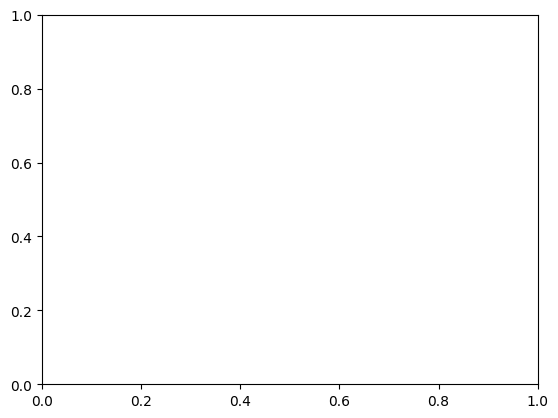

In [5]:
# Main Function

from ast import Num
import random
import numpy as np
import math
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from collections import deque
import torch
from torch import Tensor, nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
import os
from scipy.io import savemat

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")

SEED = 1
torch.manual_seed(SEED)
np.random.seed(SEED)

## GPU configuration use for faster processing
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device = "cpu"


# DNN modeling
class NeuralNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(NeuralNetwork, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear_stack = model = nn.Sequential(
            nn.Linear(self.state_size,400),
            nn.ReLU(),
            nn.Linear(400,400),
            nn.ReLU(),
            nn.Linear(400, self.action_size)
        ).to(device=device)

    def forward(self, x):
        x = x.to(device)
        Q_values = self.linear_stack(x)
        return Q_values

class DQL:
    # Initializing a Deep Neural Network
    def __init__(self):
        self.state_size = 4
        self.action_size = 5
        self.replay_buffer = deque(maxlen = 125000)
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.learning_rate = alpha
        self.main_network = NeuralNetwork(self.state_size, self.action_size).to(device)
        self.target_network = NeuralNetwork(self.state_size, self.action_size).to(device)
        self.target_network.load_state_dict(self.main_network.state_dict())
        self.optimizer = torch.optim.Adam(self.main_network.parameters(), lr = self.learning_rate)
        self.loss_func = nn.SmoothL1Loss()      # Huber Loss // Combines MSE and MAE
        self.steps_done = 0

    # Storing information of individual UAV information in their respective buffer
    def store_transition(self, state, action, reward, next_state, done):
        self.replay_buffer.append((state, action, reward, next_state, done))


    # Deployment of epsilon greedy policy
    def epsilon_greedy(self, state):
        temp = random.random()
        self.steps_done += 1
        if temp <= self.epsilon:
            action = torch.tensor([[np.random.randint(0, 4)]], device = device, dtype = torch.long)
        else:
            state = torch.unsqueeze(torch.FloatTensor(state),0)
            Q_values = self.main_network(state)
            action = Q_values.max(1)[1].view(1,1)
        return action

    # Training of the DNN
    def train(self,batch_size):
      minibatch = random.sample(self.replay_buffer, batch_size)
      minibatch = np.array(minibatch, dtype = object)
      minibatch = minibatch.reshape(batch_size,5)
      state = torch.FloatTensor(np.vstack(minibatch[:,0]))
      action = torch.LongTensor(np.vstack(minibatch[:,1]))
      reward = torch.FloatTensor(np.vstack(minibatch[:,2]))
      next_state = torch.FloatTensor(np.vstack(minibatch[:,3]))
      done = torch.Tensor(np.vstack(minibatch[:,4]))
      state = state.to(device = device)
      action = action.to(device = device)
      reward = reward.to(device = device)
      next_state = next_state.to(device = device)
      done = done.to(device = device)

      Q_next = self.target_network(next_state).detach()
      target_Q = reward.cpu().squeeze() + self.gamma * Q_next.cpu().max(1)[0].view(batch_size, 1).squeeze() * (
                1 - np.array([state[e].cpu().mean() == next_state[e].cpu().mean() for e in range(len(next_state))])
            )

      # Forward
      # Loss calculation based on loss function
      target_Q = target_Q.float()
      Q_main = self.main_network(state).gather(1, action).squeeze()
      loss = self.loss_func(target_Q.cpu().detach(), Q_main.cpu())
      # Backward
      self.optimizer.zero_grad()
      loss.backward()
      # For gradient clipping
      for param in self.main_network.parameters():
          param.grad.data.clamp_(-1,1)
      # Gradient descent
      self.optimizer.step()


u_env = UAVenv()
GRID_SIZE = u_env.GRID_SIZE
NUM_UAV = u_env.NUM_UAV
NUM_USER = u_env.NUM_USER
num_episode = 450
num_epochs = 100
discount_factor = 0.95
alpha = 3.5e-4
batch_size = 512
update_rate = 10  #50
epsilon = 0.10
random.seed(SEED)



# Keeping track of the episode reward
episode_reward = np.zeros(num_episode)
episode_user_connected = np.zeros(num_episode)

fig = plt.figure()
gs = GridSpec(1, 1, figure=fig)
ax1 = fig.add_subplot(gs[0:1, 0:1])

#creating object for 5 UAVs
UAV_OB = [None, None, None, None, None]


for k in range(NUM_UAV):
            UAV_OB[k] = DQL()
best_result = 0

for i_episode in range(num_episode):
    print(i_episode)

    # Environment reset and get the states
    u_env.reset()

    # Get the initial states
    states = u_env.get_state()
    reward = np.zeros(NUM_UAV)


    for t in range(num_epochs):
        drone_act_list = []
        # Update the target network
        for k in range(NUM_UAV):
            if t % update_rate == 0:
                UAV_OB[k].target_network.load_state_dict(UAV_OB[k].main_network.state_dict())

        # Determining the actions for all drones
        states_ten = torch.from_numpy(states)
        for k in range(NUM_UAV):
            state = states_ten[k, :]
            action = UAV_OB[k].epsilon_greedy(state.float())
            drone_act_list.append(action)


        # Find the global reward for the combined set of actions for the UAV
        temp_data = u_env.step(drone_act_list, reward)
        reward = temp_data[1]
        done = temp_data[2]
        next_state = u_env.get_state()

        # Store the transition information
        for k in range(NUM_UAV):
            ## Storing of the information on the individual UAV and it's reward value in itself.
            state = states_ten[k, :]
            action = drone_act_list[k]
            next_sta = next_state[k, :]
            reward_ind = reward[k]
            UAV_OB[k].store_transition(state, action, reward_ind, next_sta, done)

        # Calculation of the total episodic reward of all the UAVs
        # Calculation of the total number of connected User for the combination of all UAVs
        episode_reward[i_episode] += sum(reward)
        episode_user_connected[i_episode] += temp_data[4]

        states = next_state

        for k in range(NUM_UAV):
            if len(UAV_OB[k].replay_buffer) > batch_size:
                UAV_OB[k].train(batch_size)


# Assuming you have trained models in UAV_OB
for k in range(NUM_UAV):
    model_path = f'model_UAV_{k}.pth'
    torch.save(UAV_OB[k].main_network.state_dict(), model_path)

scaled_data = np.array(episode_user_connected) / 100

# Create a histogram plot
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.hist(scaled_data, bins=20, alpha=0.5, color='blue', edgecolor='black')
plt.xlabel('Number of Users Connected')
plt.ylabel('Frequency')
plt.title('Histogram of Users Connected per Episode')
plt.grid(True)
plt.show()
# Plot the accumulated reward vs episodes
fig = plt.figure()
plt.plot(range(0, num_episode), episode_reward)
plt.xlabel("Episode")
plt.ylabel("Episodic Reward")
plt.title("Episode vs Episodic Reward")
plt.show()
fig = plt.figure()



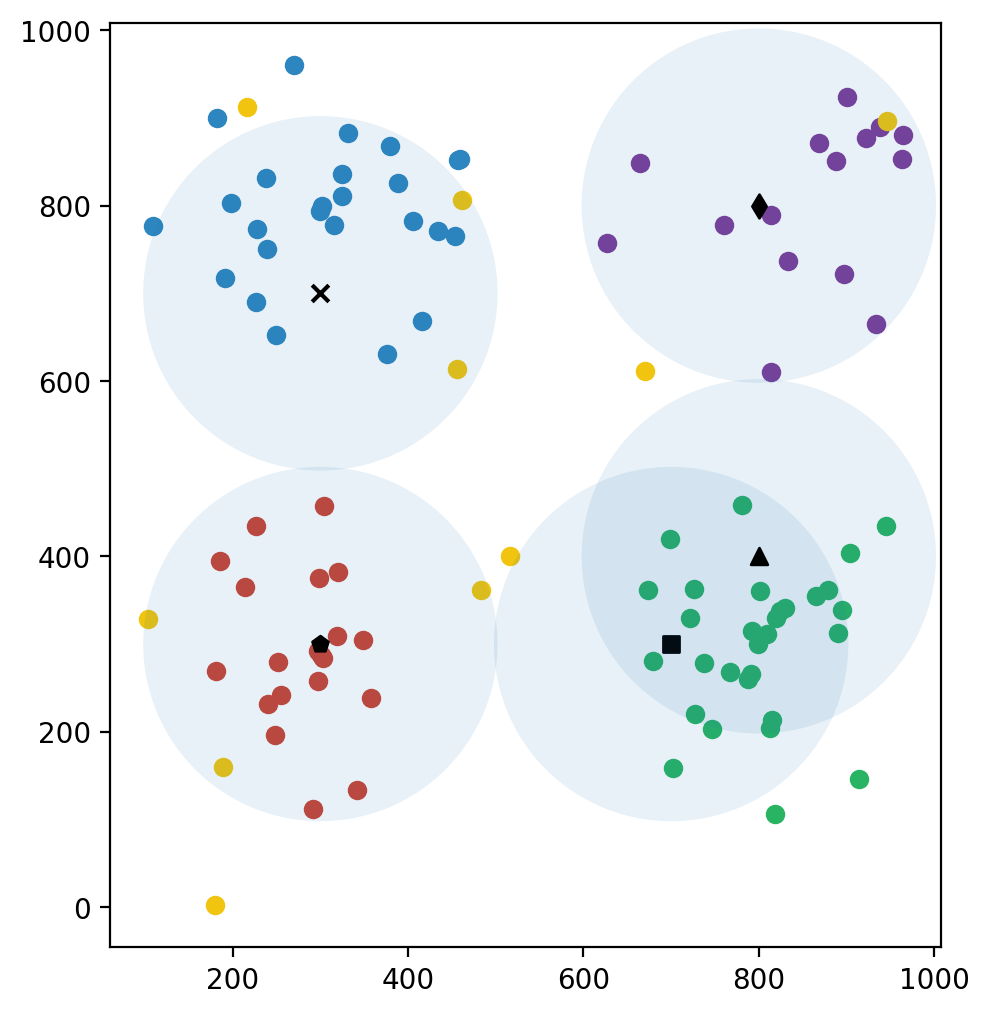

Number of user connected in episode is:  84


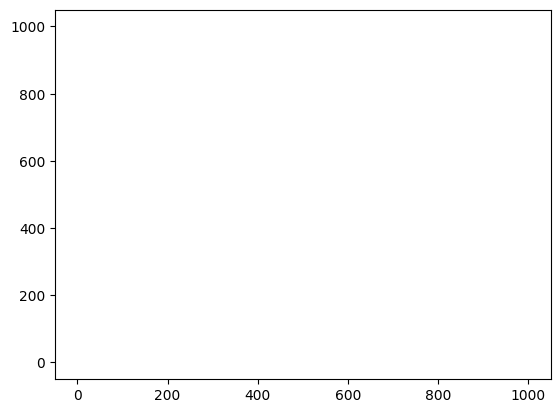

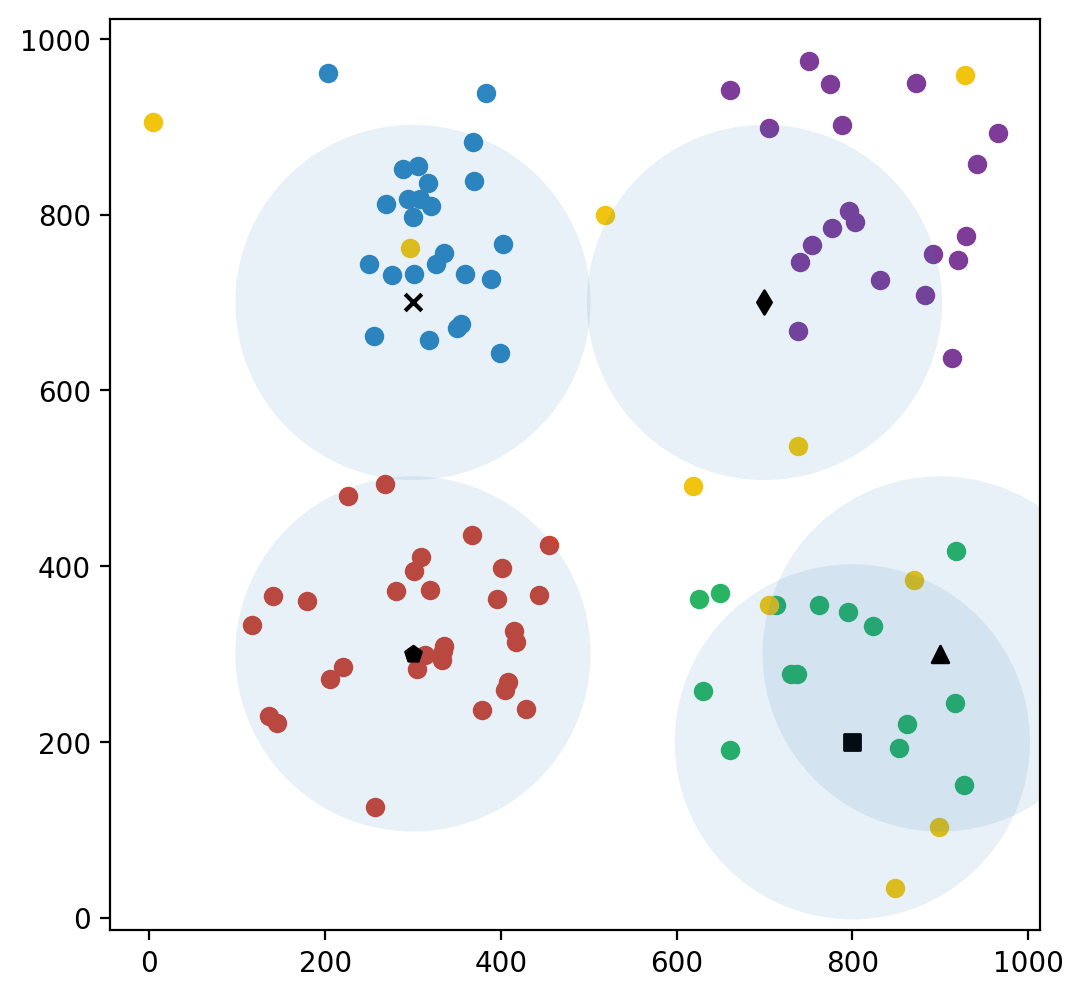

Number of user connected in episode is:  68


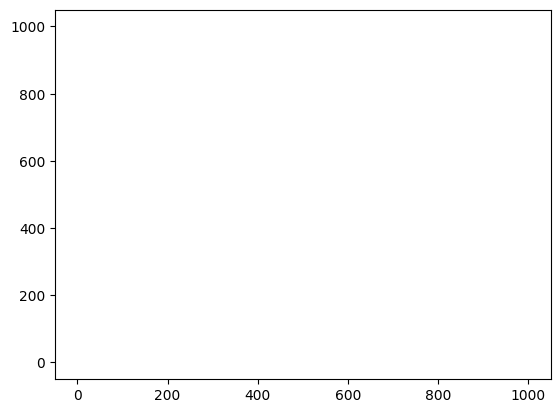

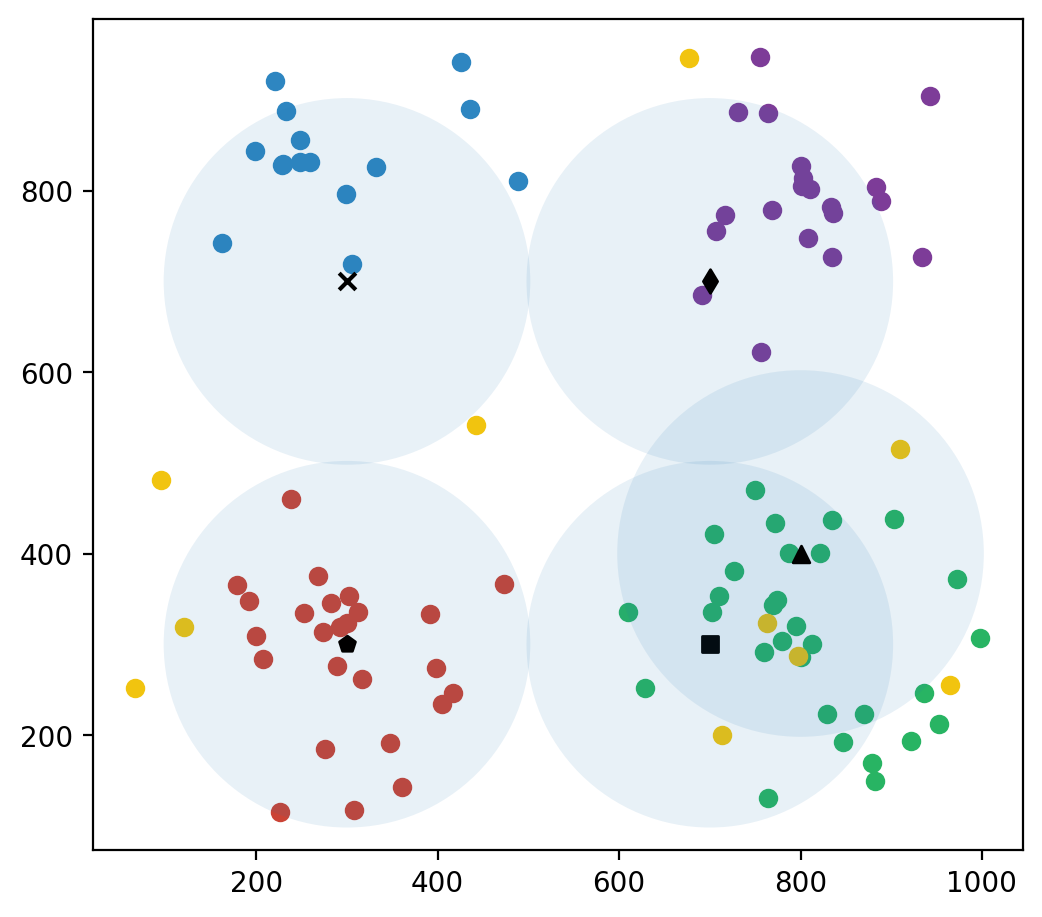

Number of user connected in episode is:  74


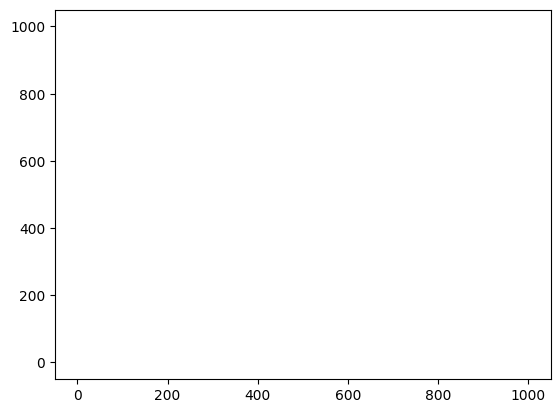

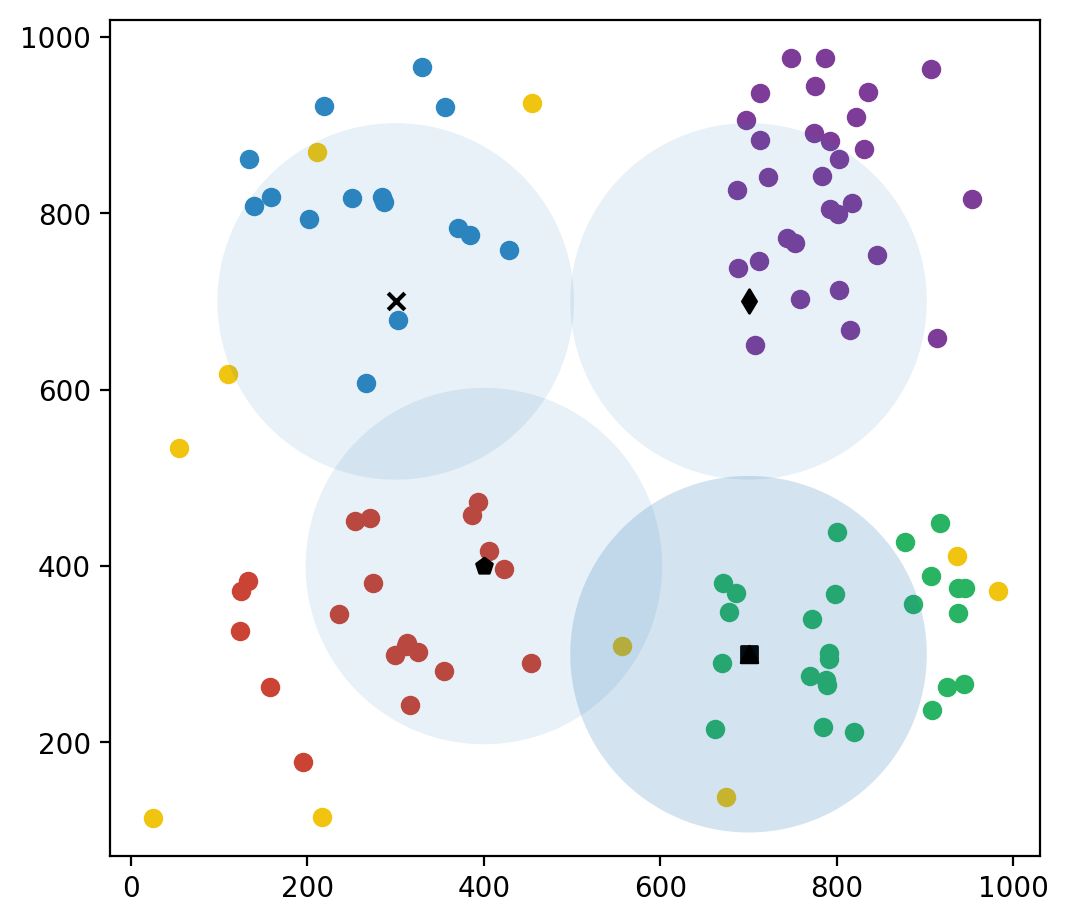

Number of user connected in episode is:  62


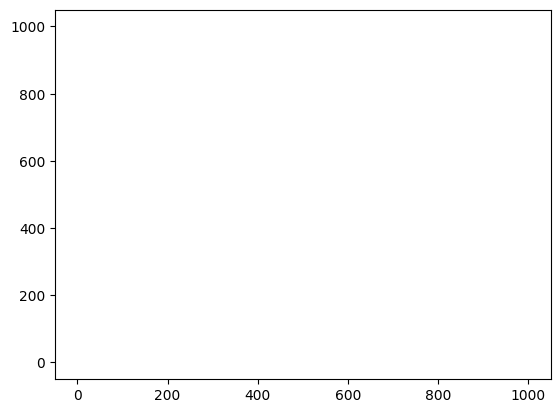

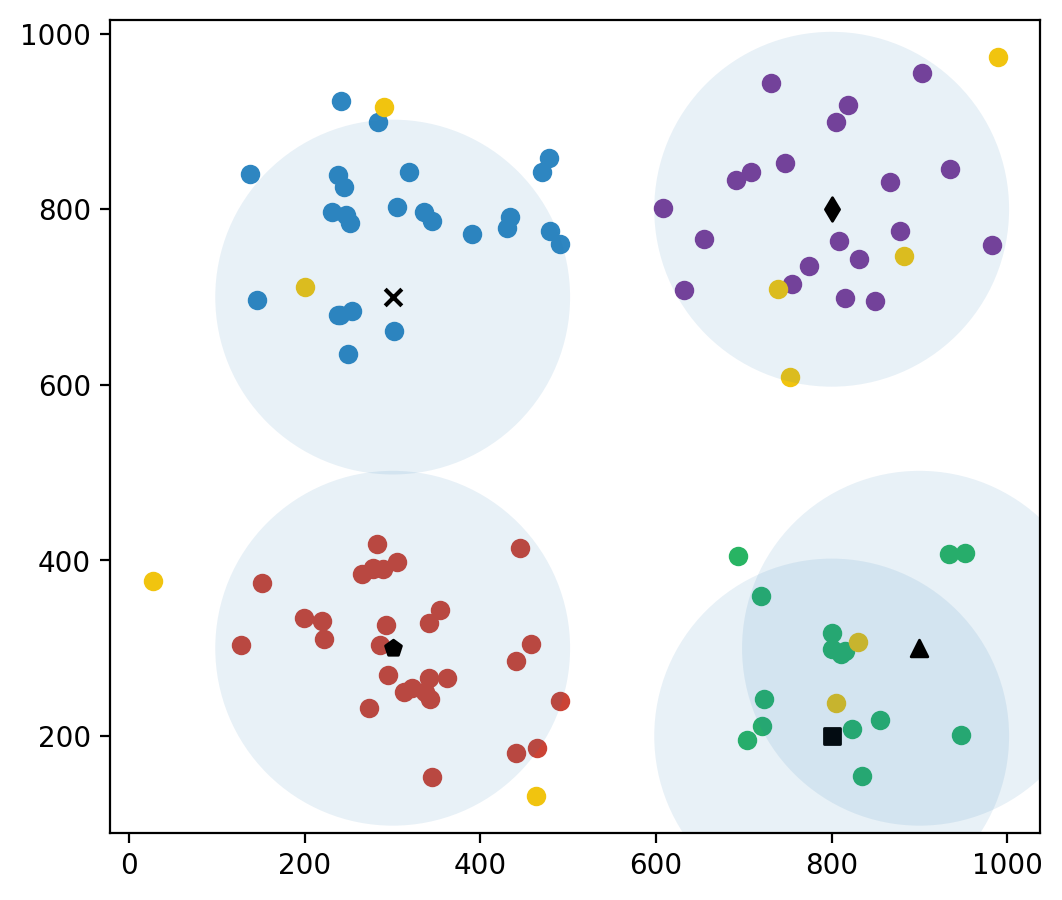

Number of user connected in episode is:  76


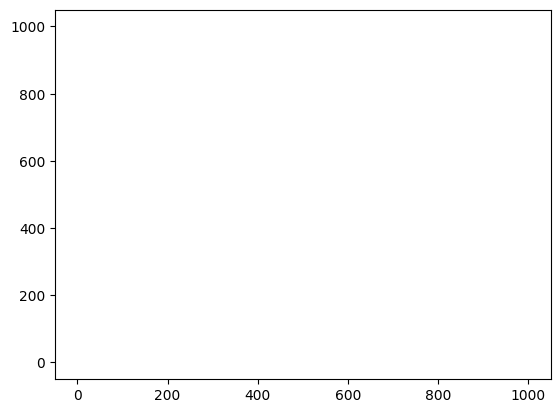

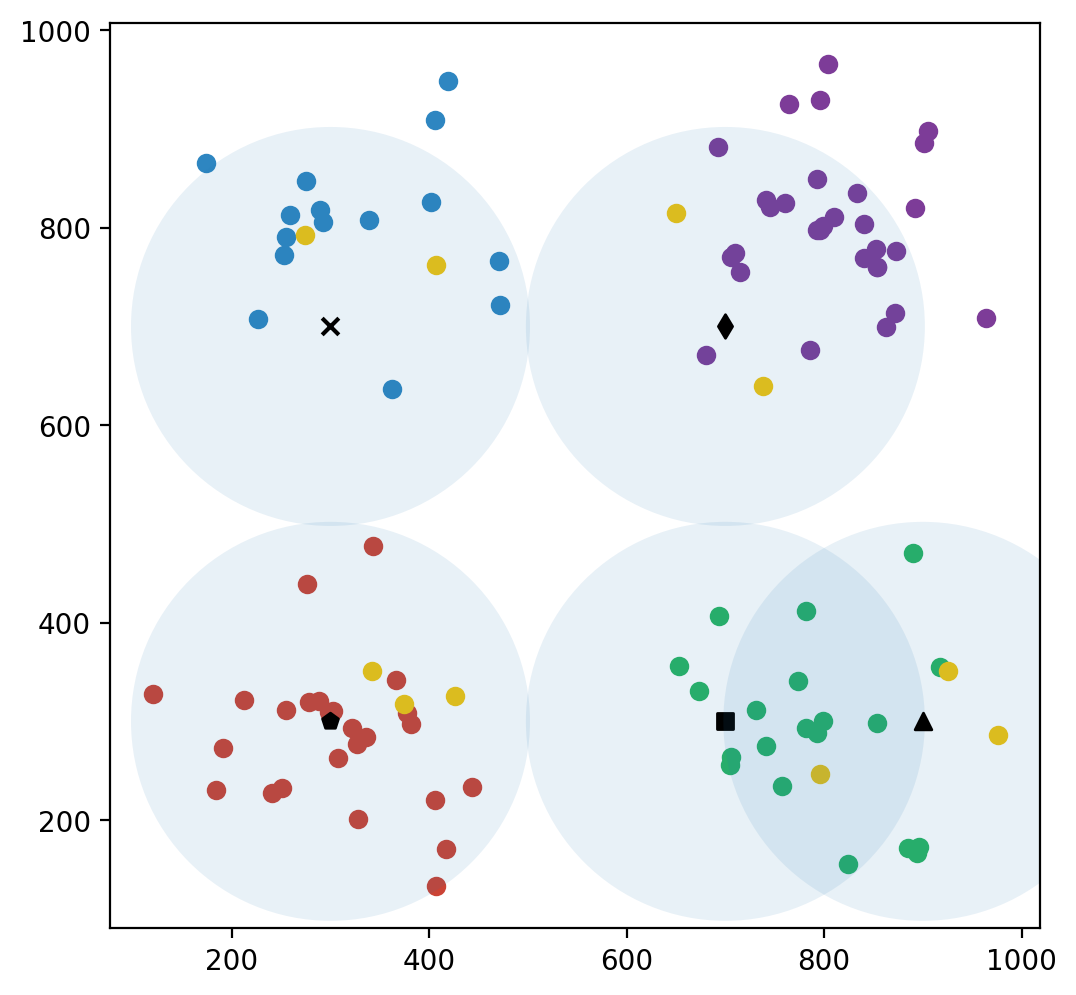

Number of user connected in episode is:  77


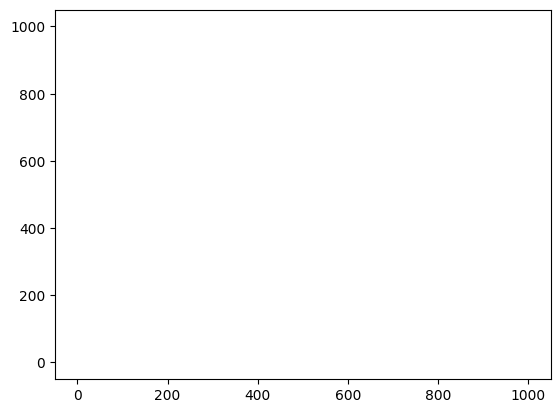

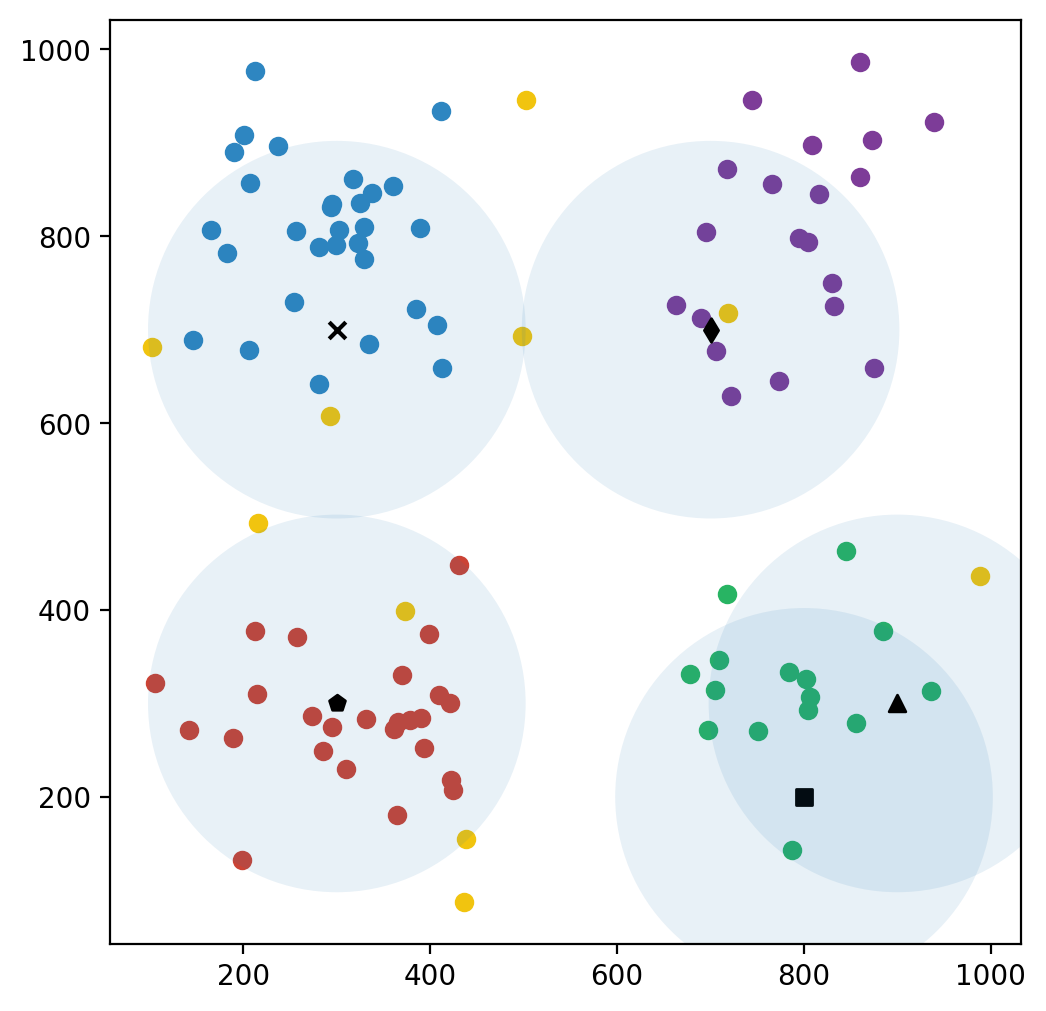

Number of user connected in episode is:  70


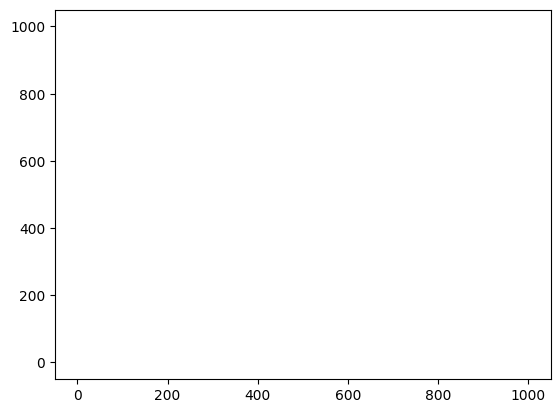

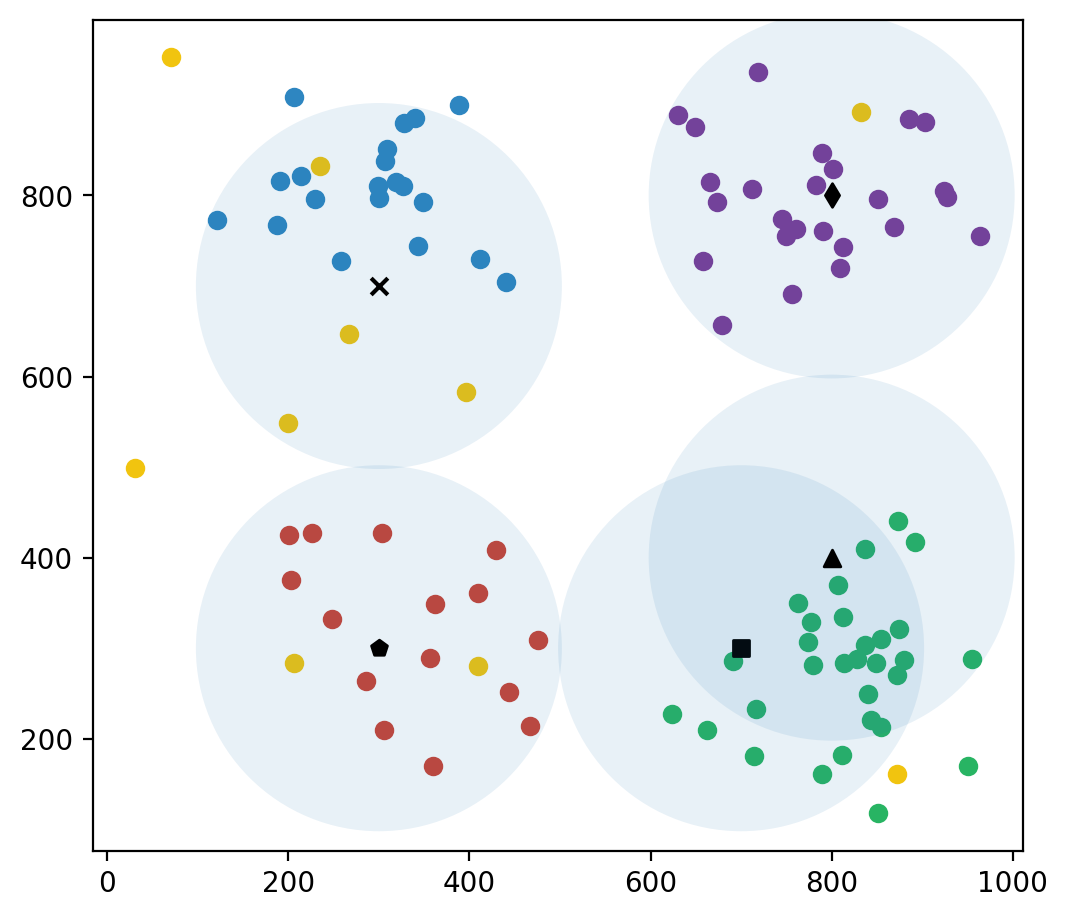

Number of user connected in episode is:  85


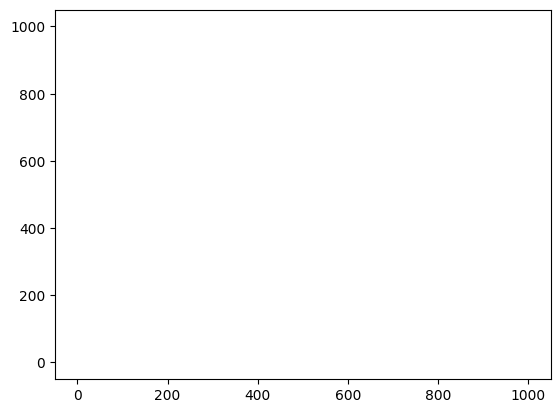

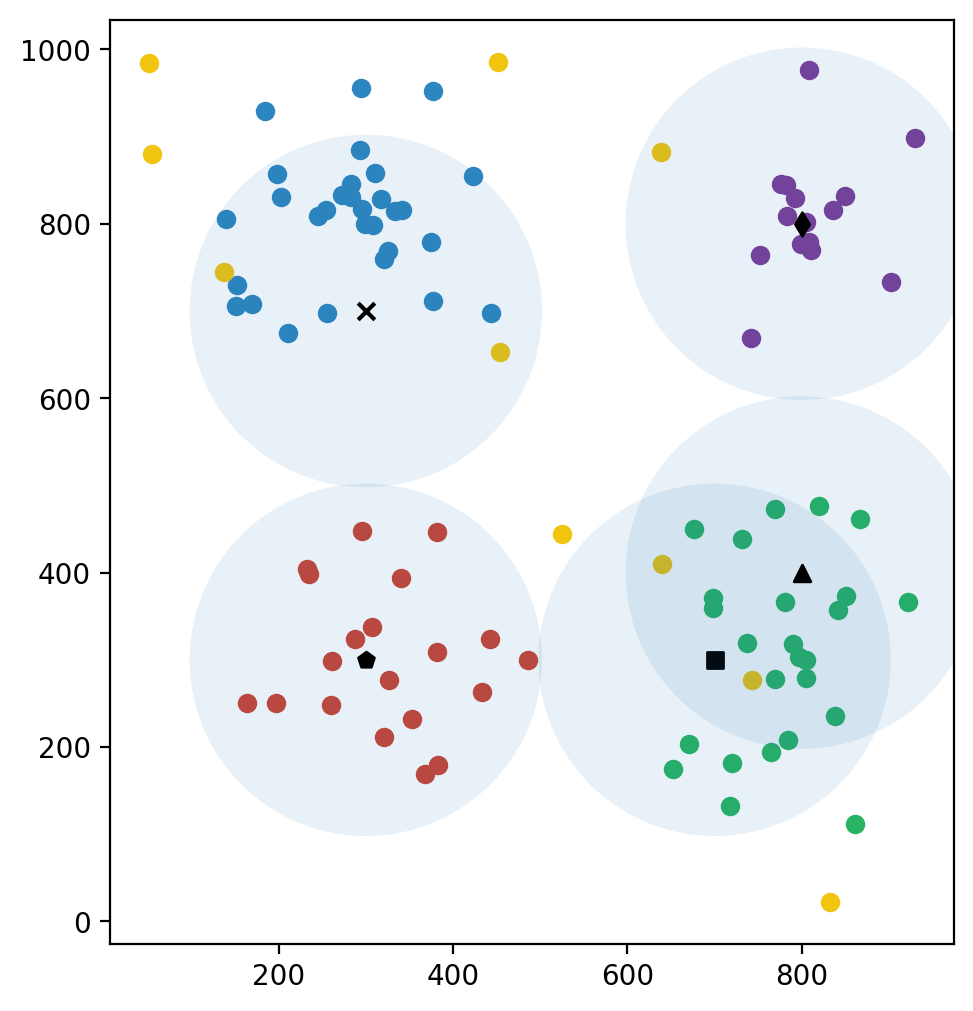

Number of user connected in episode is:  82


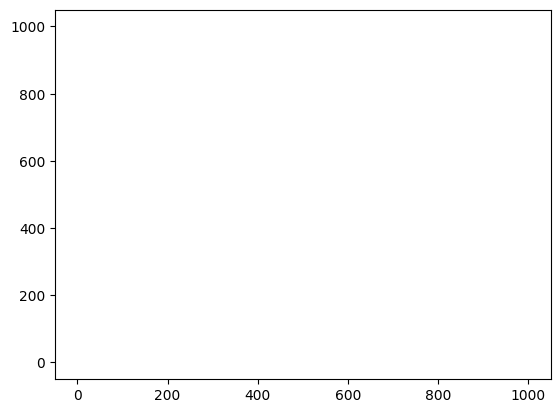

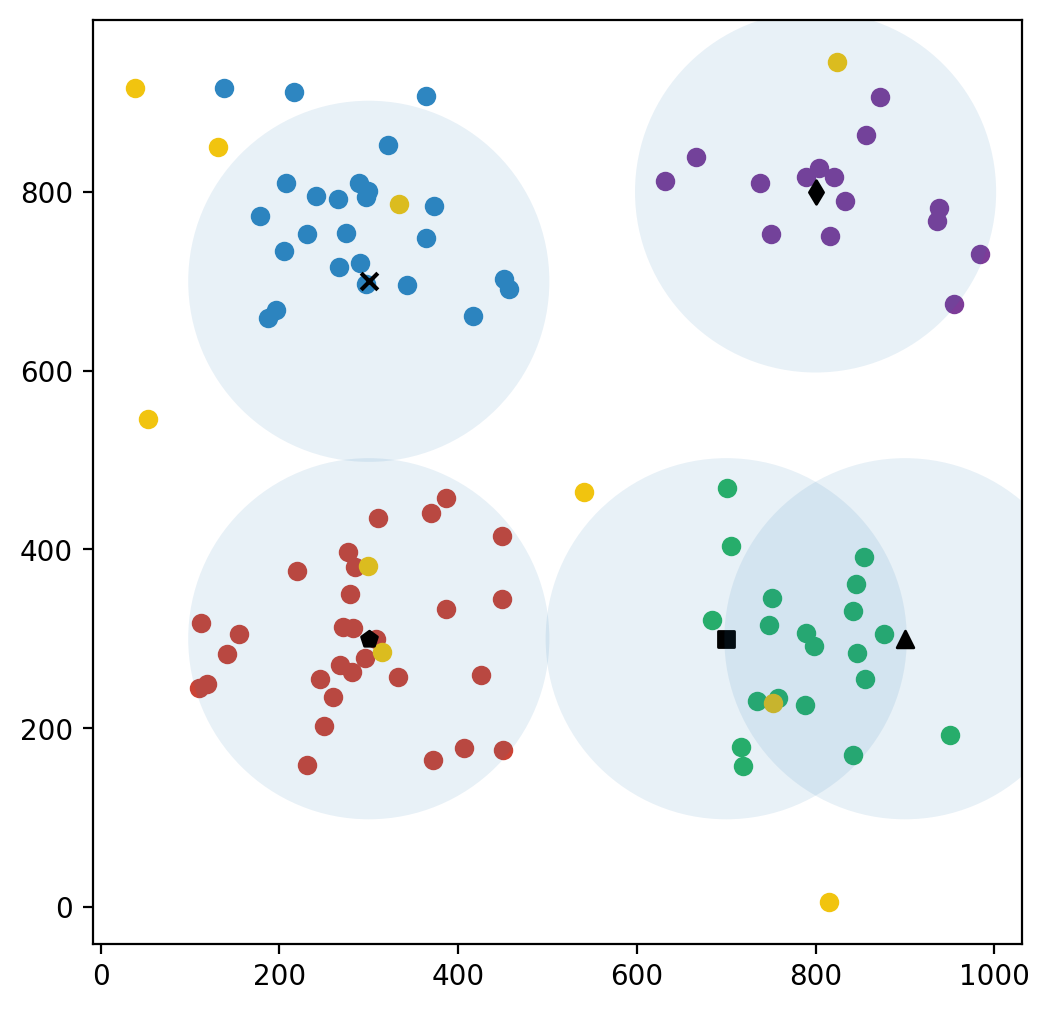

Number of user connected in episode is:  77


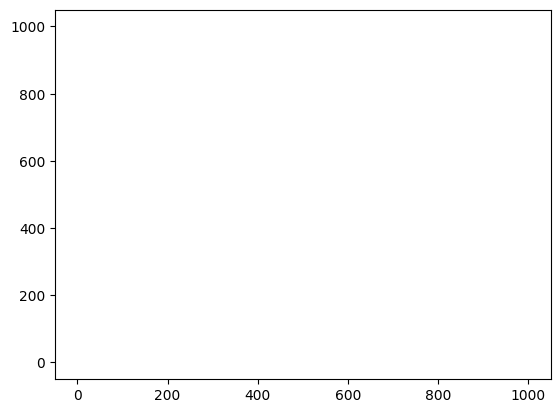

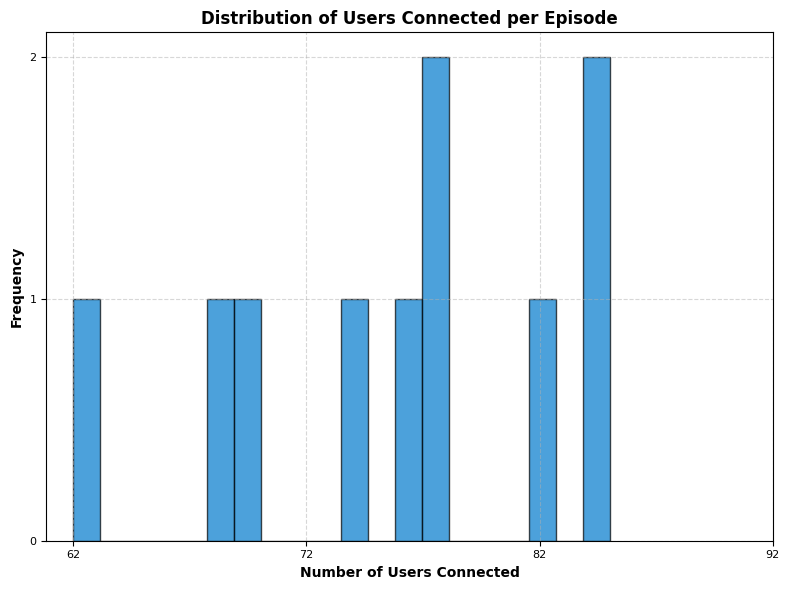

In [19]:
# Create DQL objects for testing
UAV_OB_test = [DQL() for _ in range(NUM_UAV)]

# Load the saved models for testing
for k in range(NUM_UAV):
    model_path = f'model_UAV_{k}.pth'
    UAV_OB_test[k].main_network.load_state_dict(torch.load(model_path))
    UAV_OB_test[k].main_network.eval()  # Set the model to evaluation mode

# Number of episodes for testing
num_testing_episodes = 10


# Initialize an array to store the number of users connected per episode
episode_user_connected = []

for episode in range(num_testing_episodes):
    # Reset the environment for testing
    u_env.reset()

    # Get the initial states
    states = u_env.get_state()

    for t in range(100):
        drone_act_list = []

        # Use the loaded models to make decisions
        for k in range(NUM_UAV):
            state = states[k, :]
            state = torch.unsqueeze(torch.FloatTensor(state), 0)
            with torch.no_grad():  # Disable gradient computation for evaluation
                Q_values = UAV_OB_test[k].main_network(state.float())
            best_next_action = torch.max(Q_values.cpu(), 1)[1].data.numpy()
            best_next_action = best_next_action[0]
            drone_act_list.append(best_next_action)

        # Step in the environment with the chosen actions
        temp_data = u_env.step(drone_act_list, reward)
        states = u_env.get_state()

        # Print the intermediate state and results
    u_env.render(ax1)

    print("Number of user connected in episode is: ", temp_data[4])

    # Store the number of users connected in this episode
    episode_user_connected.append(temp_data[4])

import matplotlib.pyplot as plt
import numpy as np

# Assuming episode_user_connected is your data containing the number of users connected per episode

plt.figure(figsize=(8, ))  # Standard figure size for journal papers
counts, bins, _ = plt.hist(episode_user_connected, bins=20, alpha=0.7, color='#007acc', edgecolor='black')  # Adjust alpha and color
plt.xlabel('Number of Users Connected', fontsize=10, fontweight='bold')  # Enhance axis label
plt.ylabel('Frequency', fontsize=10, fontweight='bold')  # Enhance axis label
plt.title('Distribution of Users Connected per Episode', fontsize=12, fontweight='bold')  # Enhance title
plt.grid(True, linestyle='--', alpha=0.5)  # Add gridlines

# Set the x and y ticks
x_min = min(episode_user_connected)
x_max = max(episode_user_connected)
x_ticks = np.arange(x_min, max(101, x_max+1), 10)  # Ensure last tick is at 100
plt.xticks(x_ticks, fontsize=8)  # Adjust x ticks starting from the minimum value

# Adjust y ticks to display only integer values
y_max = int(max(counts)) + 1
plt.yticks(np.arange(0, y_max, 5 if y_max > 5 else 1), fontsize=8)

plt.tight_layout()  # Improve spacing
plt.show()




